In [3]:
# with typing installed, the pip install of esm was breaking
!pip uninstall -y typing
!pip install git+https://github.com/facebookresearch/esm.git
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-whtbiex2
  Running command git clone -q https://github.com/facebookresearch/esm.git /tmp/pip-req-build-whtbiex2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import torch
import esm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from IPython.display import Image
from tqdm.auto import tqdm
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import os
%matplotlib inline

In [5]:
esm_bert, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
if torch.cuda.is_available():
    esm_bert = esm_bert.cuda()

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [8]:
import sys

# BASE_PATH variable should lead to the path where the training data is located
# training data itself represents a fasta file, with one sequence per line

BASE_PATH = ...
sys.path.append(BASE_PATH)


In [9]:
def get_seqs(file):
   seqs = []
   with open(file) as inp:
      for line in inp:
          if not line.startswith('>'):
              seqs.append(('_', line.strip()))
   return seqs

In [10]:
pos_set = get_seqs(os.path.join(BASE_PATH, 'train_po.fasta'))
pos_set_labels = [1 for item in pos_set]

neg_set = get_seqs(os.path.join(BASE_PATH, 'train_ne.fasta'))
neg_set_labels = [0 for item in neg_set]

In [11]:
data = pos_set+neg_set
labels = pos_set_labels+neg_set_labels

In [12]:
# we find out that averaging over all hidden representations works better than
# concatenation of last 4 hidden representations.

_, _, batch_tokens = batch_converter(data)

i=0
peptide_encodings = []
with torch.no_grad():
    for batch in np.split(batch_tokens, 278):
        batch = batch.cuda()
        res = esm_bert(batch, repr_layers=[33])
        batch_size = len(batch)
        encodings = res["representations"][33].mean(axis=1)
        mean = encodings.mean(axis=1).reshape(len(batch), 1)
        std = encodings.std(axis=1).reshape(len(batch), 1)
        encodings = ((encodings - mean) / std).cpu().numpy()
        peptide_encodings.extend(encodings)
        i+=1
peptide_encodings = np.array(list(zip(labels,peptide_encodings)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [13]:
import torch as T
from torch.utils.data import Dataset, DataLoader

In [14]:
if torch.cuda.is_available():
   device = "cuda"

In [15]:
class PeptidesThroughTransformerDataset(Dataset):
    def __init__(self, source_data):
        self.data_transformer = T.tensor(np.array([np.array(x, dtype=float) for x in np.take(source_data, 1, axis=1)]),
            dtype=T.float32).to(device)
        self.labels = T.tensor(np.take(source_data, 0, axis=1).astype(dtype='f')).to(device) 
        
    def __len__(self):
        return len(self.data_transformer)  

    def __getitem__(self, idx):
        if T.is_tensor(idx):
            idx = idx.tolist()
        b_data = self.data_transformer[idx, 0:]
        b_labels = self.labels[idx]
        sample = { 'data' : b_data, 
                  'class' : b_labels}
        return sample

In [16]:
from sklearn.model_selection import train_test_split


train, val = train_test_split(peptide_encodings,  test_size=0.35)

In [17]:
BATCH_SIZE = 1024

train_set = PeptidesThroughTransformerDataset(train)

val_set = PeptidesThroughTransformerDataset(val)

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(val_set, BATCH_SIZE, shuffle=True)

In [ ]:
from torch import nn

In [19]:
class AttentionClassifier(nn.Module):
    def __init__(self, embeddings_dim=1280, output_dim=1, dropout=0.1, kernel_size=9, conv_dropout = 0.1):
        super().__init__()

        self.feature_convolution = nn.Conv1d(in_channels=embeddings_dim, out_channels=embeddings_dim, 
                                             kernel_size=kernel_size, stride=1,
                                             padding=kernel_size // 2)
        self.attention_convolution = nn.Conv1d(in_channels=embeddings_dim, out_channels=embeddings_dim, 
                                               kernel_size=kernel_size, stride=1,
                                               padding=kernel_size // 2)
        
        self.softmax = nn.Softmax(dim=-1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(conv_dropout)
        self.first_layer = nn.Linear(1280,1024)
        self.bn_first = nn.BatchNorm1d(1024)

        self.second_layer = nn.Linear(1024,512)
        self.bn_second = nn.BatchNorm1d(512)

        self.output = nn.Linear(512,1) 
        self.sigmoid = nn.Sigmoid()    
   
    def forward(self, input_vector):
        input_vector = torch.unsqueeze(input_vector, dim=2)
        o = self.feature_convolution(input_vector)  
        o = self.dropout(o)
        attention = self.attention_convolution(input_vector)
        o = torch.sum(o * self.softmax(attention), dim=-1)  # [batchsize, embeddings_dim]
        layer1 = self.dropout(self.relu(self.bn_first(self.first_layer(o))))
        layer2 = self.dropout(self.relu(self.bn_second(self.second_layer(layer1))))
        prob = self.sigmoid(self.output(layer2))
        return prob

In [20]:
import torch.optim as optim

model = AttentionClassifier().to(device)

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=1e-6)
criterion = nn.BCELoss()

In [22]:
def train(model, iterator, optimizer, criterion, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        output = model(batch['data'])

        loss = criterion(output.squeeze(), batch['class'])
        loss.backward()
        optimizer.step()

        epoch_loss +=loss.item()

        history.append(loss.cpu().data.numpy())

        if (i+1)%2 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history:
               ax[1].plot(train_history, label='general train history')
               ax[1].set_xlabel('Epoch')
            if valid_history:
               ax[1].plot(valid_history, label='general valid history')
               ax[1].set_xlabel('Epoch')
            plt.legend()

            plt.show()
    return epoch_loss / (i+1)

In [23]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            batch = {k: v.to(device) for k, v in batch.items()}
            output = model(batch['data'])
            loss = criterion(output.squeeze(), batch['class'])
            epoch_loss += loss.item()
        return epoch_loss / (i+1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
import time
import math
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

matplotlib.rcParams.update({'figure.figsize': (16,12),
                            'font.size': 14})

%matplotlib inline


In [25]:
# weights of the best model (in terms of validation score) should be saved in that file

MODEL_PATH = os.path.join(BASE_PATH, 'la_model2.pt')

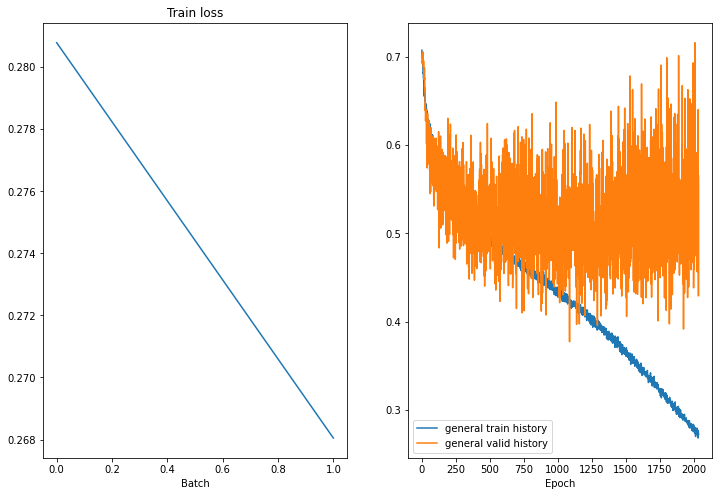

	Train Loss: 0.274
	Val. Loss: 0.488


KeyboardInterrupt: ignored

In [26]:
train_history = []
valid_history = []

N_EPOCHS = 3000

best_valid_loss = float('inf')



for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, train_history, valid_history)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

        # comment this block if saving of model weights 
        # aren't desired

        ####
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss,
            }, MODEL_PATH)
        ####

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f}')

In [36]:
# comment this block if no saving of the model weights wasn't performed

best_model = torch.load(MODEL_PATH)
model.load_state_dict(best_model['model_state_dict'])
optimizer.load_state_dict(best_model['optimizer_state_dict'])
model.eval()

AttentionClassifier(
  (feature_convolution): Conv1d(1280, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
  (attention_convolution): Conv1d(1280, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
  (softmax): Softmax(dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (first_layer): Linear(in_features=1280, out_features=1024, bias=True)
  (bn_first): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (second_layer): Linear(in_features=1024, out_features=512, bias=True)
  (bn_second): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [37]:
threshold=0.5
results = {}

TP = 0
TN = 0
FN = 0
FP = 0

with torch.no_grad():
    for batch in valid_loader:
        batch['data'].to(device)
        batch['class'].to(device)
        preds =  (model(batch['data']).squeeze() > threshold).int() 
        true = batch['class'].int()
        TP += torch.sum((preds == 1) & (preds == true), 0)
        TN += torch.sum((preds == 0) & (preds == true), 0)
        FN += torch.sum((preds == 1) & (preds != true), 0)
        FP += torch.sum((preds == 0) & (preds != true), 0)

results["TP"] = TP
results["TN"] = TN
results["FN"] = FN
results["FP"] = FP
results["Sensitivity"] = TP/(TP+FN)
results["Specificity"] = TN/(TN+FP)
results["Accuracy"] = (TP+TN)/(TP+TN+FP+FN)

In [38]:
print(f' Acc {results["Accuracy"]} Sensitivity {results["Sensitivity"]} Specificity {results["Specificity"]}')

 Acc 0.7805789113044739 Sensitivity 0.7789473533630371 Specificity 0.7824351191520691


In [40]:
###### Benchmark results ########

In [41]:
pos_test_set = get_seqs(os.path.join(BASE_PATH, 'benchmark_po.fasta'))
pos_test_set_labels = [1 for item in pos_test_set]

neg_test_set = get_seqs(os.path.join(BASE_PATH, 'benchmark_ne.fasta'))
neg_test_set_labels = [0 for item in neg_test_set]

test_data = pos_test_set+neg_test_set
test_labels = pos_test_set_labels+neg_test_set_labels

In [42]:
_, _, test_batch_tokens = batch_converter(test_data)

i=0
test_peptide_encodings = []
with torch.no_grad():
    for batch in np.split(test_batch_tokens, 188):
        batch = batch.cuda()
        res = esm_bert(batch, repr_layers=[33])
        batch_size = len(batch)
        encodings = res["representations"][33].mean(axis=1)
        mean = encodings.mean(axis=1).reshape(len(batch), 1)
        std = encodings.std(axis=1).reshape(len(batch), 1)
        encodings = ((encodings - mean) / std).cpu().numpy()
        test_peptide_encodings.extend(encodings)
        i+=1

test_peptide_encodings = np.array(list(zip(test_labels,test_peptide_encodings)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [43]:
BATCH_SIZE = 100
test_set = PeptidesThroughTransformerDataset(test_peptide_encodings)
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=True)

In [44]:
TP = 0
TN = 0
FN = 0
FP = 0
results_test = {}

with torch.no_grad():
    for batch in test_loader:
        batch['data'].to(device)
        batch['class'].to(device)
        preds = (model(batch['data']).squeeze() > threshold).int() 
        true = batch['class'].int()
        TP += torch.sum((preds == 1) & (preds == true), 0)
        TN += torch.sum((preds == 0) & (preds == true), 0)
        FN += torch.sum((preds == 1) & (preds != true), 0)
        FP += torch.sum((preds == 0) & (preds != true), 0)

results_test["TP"] = TP
results_test["TN"] = TN
results_test["FN"] = FN
results_test["FP"] = FP
results_test["Sensitivity"] = TP/(TP+FN)
results_test["Specificity"] = TN/(TN+FP)
results_test["Accuracy"] = (TP+TN)/(TP+TN+FP+FN)
      

In [45]:
print(f' Acc {results_test["Accuracy"]} Sensitivity {results_test["Sensitivity"]} Specificity {results_test["Specificity"]}')

 Acc 0.7978723645210266 Sensitivity 0.8111110925674438 Specificity 0.7857142686843872


In [47]:
MCC = (TP*TN - FP*FN) / ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5
MCC

tensor(0.5963, device='cuda:0')